 As a Data Scientist on the airline's Data Team, you are provided with the tweets shared by customers regarding their experience with the airline's services. The objective is to analyze the data and build a predictive model that can parse the customer reviews and predict the sentiment of the customer.

* tweet_id - A unique identifier for each tweet                                                          
* airline_sentiment - The sentiment label of the tweet, such as positive, negative, or neutral                                               
* airline_sentiment_confidence - The confidence level associated with the sentiment label                               
* negativereason - A category indicating the reason for negative sentiment                                                   
* negativereason_confidence - The confidence level associated with the negative reason                                    
*airline - The airline associated with the tweet                                                                   
* airline_sentiment_gold - Gold standard sentiment label                                               
* name - The username of the tweet author    
* retweet_count - The number of times the tweet has been retweeted
* text - The actual text content of the tweet.
* tweet_coord - Coordinates of the tweet
* tweet_created - The timestamp when the tweet was created
* tweet_location - The location mentioned in the tweet
* user_timezone - The timezone of the tweet author

In [1]:
# Import necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import modules from scikit-learn for machine learning tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report,make_scorer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ASUS/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('Dataset - US_Airways.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570310600460525568,negative,0.6292,Flight Booking Problems,0.3146,US Airways,NaN,jhazelnut,NaN,0,@USAirways is there a better time to call? My...,NaN,2015-02-24 11:53:37 -0800,NaN,NaN
1,570310144459972608,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,GAKotsch,NaN,0,@USAirways and when will one of these agents b...,NaN,2015-02-24 11:51:48 -0800,NaN,Atlantic Time (Canada)
2,570309340952993796,neutral,1.0000,NaN,NaN,US Airways,NaN,DebbiMcGinnis,NaN,0,@USAirways is a DM possible if you aren't foll...,NaN,2015-02-24 11:48:37 -0800,Missourah,Hawaii
3,570309000279023616,neutral,1.0000,NaN,NaN,US Airways,NaN,AshleyKAtherton,NaN,0,@USAirways Fortunately you have staff like Lyn...,NaN,2015-02-24 11:47:16 -0800,NaN,Central Time (US & Canada)
4,570308799950692353,negative,1.0000,Customer Service Issue,0.6452,US Airways,NaN,retardedlarry,NaN,0,@USAirways just hung up on me again. Another ...,NaN,2015-02-24 11:46:28 -0800,NaN,NaN


In [3]:
data.shape

(2913, 15)

In [4]:
data.isna().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                   650
negativereason_confidence        443
airline                            0
airline_sentiment_gold          2910
name                               0
negativereason_gold             2911
retweet_count                      0
text                               0
tweet_coord                     2763
tweet_created                      0
tweet_location                  1069
user_timezone                   1062
dtype: int64

In this dataset, our main focus is on two columns, namely 'content' and 'sentiment.' Fortunately, these columns do not contain any missing values. As a result, there is no need to address missing values in other columns.

In [5]:
data['airline_sentiment'].value_counts()

airline_sentiment
negative    2263
neutral      381
positive     269
Name: count, dtype: int64

In [6]:
data.duplicated().sum()

0

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2913 entries, 0 to 2912
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      2913 non-null   int64  
 1   airline_sentiment             2913 non-null   object 
 2   airline_sentiment_confidence  2913 non-null   float64
 3   negativereason                2263 non-null   object 
 4   negativereason_confidence     2470 non-null   float64
 5   airline                       2913 non-null   object 
 6   airline_sentiment_gold        3 non-null      object 
 7   name                          2913 non-null   object 
 8   negativereason_gold           2 non-null      object 
 9   retweet_count                 2913 non-null   int64  
 10  text                          2913 non-null   object 
 11  tweet_coord                   150 non-null    object 
 12  tweet_created                 2913 non-null   object 
 13  twe

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,2913.0,5.691208e+17,7.676358e+14,5.676433e+17,5.684797e+17,5.693176e+17,5.697157e+17,5.703106e+17
airline_sentiment_confidence,2913.0,9.215784e-01,1.499961e-01,3.400000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,2470.0,6.871717e-01,3.078601e-01,0.000000e+00,6.223500e-01,6.777000e-01,1.000000e+00,1.000000e+00
retweet_count,2913.0,8.547889e-02,1.172269e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


- `tweet_id` is a unique ID for a tweet, so we can discard it from our analysis
- We see that there is minimal retweeting of customers tweets
    - However, this might vary by customer sentiment, so we'll check for that later

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5412\2173674368.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x='airline_sentiment', palette='coolwarm')


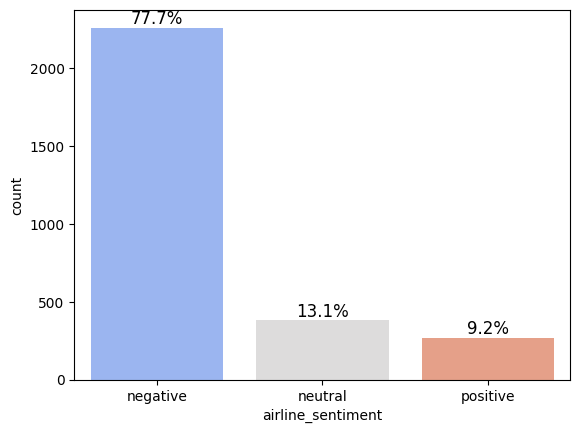

In [9]:
ax = sns.countplot(data=data, x='airline_sentiment', palette='coolwarm')

# Calculate total count
total = len(data)

# Add percentage labels
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Position
                ha='center', va='bottom', fontsize=12, color='black')

# Show plot
plt.show()

- ax.patches iterates over all bars in the countplot.
- p.get_height() gets the count value of each bar.
- (p.get_x() + p.get_width() / 2, p.get_height()) positions the text at the top center of each bar.
- ha='center' aligns text horizontally at the center of the bar.
- va='bottom' ensures the text is placed slightly above the bar.
- fontsize=12, color='black' makes the text clear and readable.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5412\781471640.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x='negativereason', palette='coolwarm')


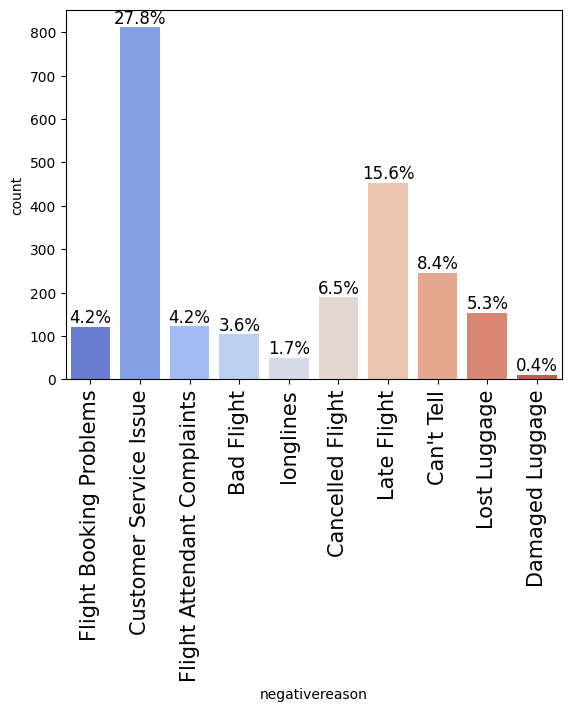

In [10]:
ax = sns.countplot(data=data, x='negativereason', palette='coolwarm')

# Calculate total count
total = len(data)

# Add percentage labels
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Position
                ha='center', va='bottom', fontsize=12, color='black')

# Show plot
plt.xticks(rotation=90, fontsize=15)
plt.show()

* The predominant causes of negative tweets appear to be customer service issues (28%) and late flights (16%)

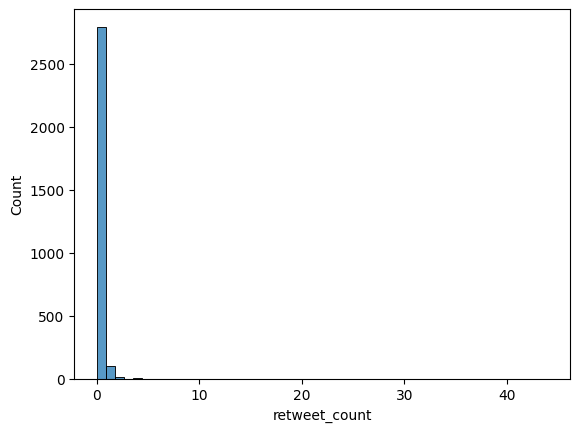

In [11]:
sns.histplot(data = data , x = 'retweet_count',bins = 50);

- A majority of the customer tweets are not re-tweeted
- The lower number of retweet counts suggests that customers are less inclined to retweet

<Axes: xlabel='airline_sentiment', ylabel='retweet_count'>

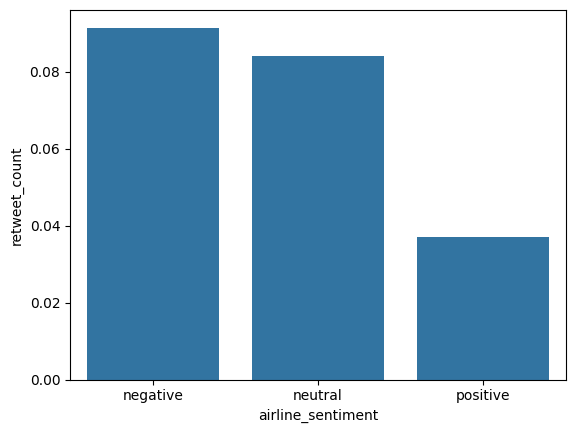

In [12]:
sns.barplot(data = data , x = 'airline_sentiment' , y = 'retweet_count',errorbar=('ci', False))

* On average, negative sentiment tweets get re-tweeted the most

## **Text Preprocessing**

### **Removing special characters**

In [13]:
def remove_special_character(text):
    pattern = '[^A-Za-z0-9]+'
    new_text = ''.join(re.sub(pattern,' ',text))
    return new_text

In [14]:
data['cleaned_text'] = data['text'].apply(remove_special_character)
data.loc[0:3 , ['text','cleaned_text']]

,text,cleaned_text
0,@USAirways is there a better time to call? My...,USAirways is there a better time to call My f...
1,@USAirways and when will one of these agents b...,USAirways and when will one of these agents b...
2,@USAirways is a DM possible if you aren't foll...,USAirways is a DM possible if you aren t foll...
3,@USAirways Fortunately you have staff like Lyn...,USAirways Fortunately you have staff like Lyn...


### **Converting to lower case**

In [15]:
data['cleaned_text'] = data['cleaned_text'].str.lower()
data.loc[0:3 , ['text','cleaned_text']]

,text,cleaned_text
0,@USAirways is there a better time to call? My...,usairways is there a better time to call my f...
1,@USAirways and when will one of these agents b...,usairways and when will one of these agents b...
2,@USAirways is a DM possible if you aren't foll...,usairways is a dm possible if you aren t foll...
3,@USAirways Fortunately you have staff like Lyn...,usairways fortunately you have staff like lyn...


### **Removing extra whitespaces**

In [16]:
data['cleaned_text'] = data['cleaned_text'].str.strip()
data.loc[0:3 , ['text','cleaned_text']]

,text,cleaned_text
0,@USAirways is there a better time to call? My...,usairways is there a better time to call my fl...
1,@USAirways and when will one of these agents b...,usairways and when will one of these agents be...
2,@USAirways is a DM possible if you aren't foll...,usairways is a dm possible if you aren t follo...
3,@USAirways Fortunately you have staff like Lyn...,usairways fortunately you have staff like lynn...


### **Removing Stopwords**

* The idea with stop word removal is to **exclude words that appear frequently throughout** all the documents in the corpus.
* Pronouns and articles are typically categorized as stop words.
* The `NLTK` library has an in-built list of stop words and it can utilize that list to remove the stop words from a dataset.

In [17]:
def remove_stopwords(text):
    words = text.split()
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])
    return new_text

In [18]:
data['cleaned_text_after_stopwords'] = data['cleaned_text'].apply(remove_stopwords)
data.loc[0:3 , ['text','cleaned_text_after_stopwords']]

,text,cleaned_text_after_stopwords
0,@USAirways is there a better time to call? My...,usairways better time call flight friday need ...
1,@USAirways and when will one of these agents b...,usairways one agents available speak
2,@USAirways is a DM possible if you aren't foll...,usairways dm possible following
3,@USAirways Fortunately you have staff like Lyn...,usairways fortunately staff like lynn deedee a...


### **Stemming**

Stemming is a language processing method that chops off word endings to find the root or base form of words.

For example,

- Original Word: Jumping, Stemmed Word: Jump
- Original Word: Running, Stemmed Word: Run

The Porter Stemmer is one of the widely-used algorithms for stemming, and it shorten words to their root form by removing suffixes.

In [19]:
ps = PorterStemmer()

In [20]:
def porter_stemmer(text):
    words = text.split()
    new_text = ' '.join([ps.stem(word) for word in words])
    return new_text

In [21]:
data['final_cleaned_text'] = data['cleaned_text_after_stopwords'].apply(porter_stemmer)
data.loc[0:3 , ['text','final_cleaned_text']]

,text,final_cleaned_text
0,@USAirways is there a better time to call? My...,usairway better time call flight friday need c...
1,@USAirways and when will one of these agents b...,usairway one agent avail speak
2,@USAirways is a DM possible if you aren't foll...,usairway dm possibl follow
3,@USAirways Fortunately you have staff like Lyn...,usairway fortun staff like lynn deede actual u...


## **Text Vectorization**
## **1) Count Vectorizer**
- We'll use the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class of sklearn to vectorize the data using Bag of Words (BoW).

- We first create the document-term matrix, where each value in the matrix stores the count of a term in a document.

- We then consider only the top *n* terms by frequency
    - *n* is a hyperparameter that one can change and experiment with

In [22]:
bow_vec = CountVectorizer(max_features = 1000)

data_features_BOW = bow_vec.fit_transform(data['final_cleaned_text'])

# Convert the data features to array
data_features_BOW = data_features_BOW.toarray()

# Shape of the feature vector
data_features_BOW.shape

(2913, 1000)

In [23]:
words = bow_vec.get_feature_names_out()
words

array(['000', '10', '100', '11', '12', '13', '14', '15', '150', '16',
       '18', '19', '1hr', '1st', '20', '200', '21', '22', '23', '24',
       '25', '28', '2hr', '2nd', '2x', '30', '30pm', '3rd', '40', '428',
       '4322', '45', '50', '60', '680', '699', '719', '728', '75', '800',
       '8pm', '90', 'aa', 'aadvantag', 'abl', 'absolut', 'abysm',
       'accept', 'access', 'accommod', 'account', 'acct', 'action',
       'actual', 'ad', 'add', 'addit', 'address', 'admir', 'advantag',
       'advisori', 'affect', 'afford', 'afternoon', 'agenc', 'agent',
       'ago', 'ahead', 'air', 'airlin', 'airplan', 'airport', 'airway',
       'allow', 'almost', 'alon', 'alreadi', 'also', 'altern', 'alway',
       'amaz', 'american', 'americanair', 'amount', 'amp', 'angri',
       'announc', 'annoy', 'anoth', 'answer', 'anymor', 'anyon', 'anyth',
       'anyway', 'anywher', 'apolog', 'app', 'appar', 'appli', 'appreci',
       'area', 'argu', 'around', 'arriv', 'asap', 'ask', 'assign',
       'ass

In [24]:
df_bow = pd.DataFrame(data_features_BOW , columns = words)
df_bow.head()

,000,10,100,11,12,13,14,15,150,16,...,ye,yeah,year,yell,yep,yesterday,yet,yr,yuma,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **2) Word2Vec**
- `Word2Vec` is imported from Gensim library

- `Word2Vec` takes the following important parameters:
    1. `word_list`: List of all words in all documents
    2. `vector_size`: Determines the size of the word vectors
    2. `min_count`: It will ignore all the words with a total frequency lower than this.
    3. `Workers`: These are the number of threads to train the model.
    4. `window`: Size of context relative to target word.

- By default, it creates word vectors of size 100.

In [28]:
from gensim.models import Word2Vec

In [29]:
word_list = [item.split(' ') for item in data['final_cleaned_text'].values]

In [31]:
vec_size = 300
model_w2v = Word2Vec(word_list , vector_size = vec_size , min_count = 1, workers = 6, window = 5)

In [36]:
# Checking the size of the vocabulary
print('Length of vocabulary:', len(list(model_w2v.wv.key_to_index)))

Length of vocabulary: 4189


In [38]:
# Checking top 5 similar words to the word 'bad'
model_w2v.wv.similar_by_word('bad',topn = 5)

[('usairway', 0.9997556209564209),
 ('issu', 0.9997449517250061),
 ('call', 0.9997432231903076),
 ('time', 0.9997391104698181),
 ('weather', 0.999738335609436)]

In [39]:
# Checking the word embedding of a random word
model_w2v.wv['bad']

array([-0.07716205,  0.17595422, -0.00295907,  0.11173773, -0.02988237,
       -0.15025525,  0.13318393,  0.36318427, -0.0037891 , -0.09775747,
        0.00092656, -0.09790476, -0.03250261, -0.03366446, -0.08875498,
       -0.11697136,  0.05039395, -0.04031936,  0.02735309, -0.08985852,
       -0.05789633,  0.01685483,  0.1424113 , -0.01119764,  0.08235014,
        0.02427016, -0.18379831,  0.00411992, -0.06335234, -0.11853778,
       -0.00522234, -0.07106957, -0.01091567, -0.01475344, -0.03857872,
        0.02671023,  0.07298531, -0.18352367, -0.05045033, -0.00372088,
       -0.15941052,  0.03557865, -0.02414029, -0.13982992,  0.08654758,
        0.15637225,  0.06497626, -0.00075405,  0.0277419 ,  0.14285344,
        0.01047314,  0.04439531, -0.08394852,  0.03998262,  0.01215658,
        0.14109956,  0.03014556, -0.02648213, -0.0550765 ,  0.02753058,
       -0.05774567, -0.04389295, -0.04236936, -0.03123733,  0.00562004,
        0.03856217,  0.04961552,  0.01651526, -0.05902469, -0.10

In [40]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_w2v.wv.key_to_index)

# Retrieving word vectors for all the words present in the model's vocabulary
word_vec = model_w2v.wv[words]

# Retrieving word vectors for all the words present in the model's vocabulary
word_vector_dict = dict(zip(words, word_vec))

In [41]:
def average_vectorizer_Word2Vec(doc):
    feature_vector = np.zeros((vec_size) , dtype = 'float64')
    words_in_vocab = [word for word in doc.split() if word in words]
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)
    return feature_vector

In [42]:
df_word2vec = pd.DataFrame(data['final_cleaned_text'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_word2vec

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 290,Feature 291,Feature 292,Feature 293,Feature 294,Feature 295,Feature 296,Feature 297,Feature 298,Feature 299
0,-0.119528,0.285296,-0.001501,0.174147,-0.042883,-0.245989,0.214598,0.585011,-0.006168,-0.157489,...,-0.026738,0.368923,0.161158,-0.068302,0.142998,0.345711,0.019674,-0.187428,0.180542,-0.133726
1,-0.133272,0.312746,-0.001084,0.192017,-0.046441,-0.272656,0.236244,0.642431,-0.008219,-0.173887,...,-0.032252,0.407269,0.177288,-0.075935,0.157289,0.379319,0.023614,-0.206737,0.200780,-0.148424
2,-0.100499,0.236636,-0.001408,0.144335,-0.036094,-0.205210,0.175626,0.485078,-0.004959,-0.129866,...,-0.025067,0.306747,0.134429,-0.055558,0.118788,0.286310,0.017090,-0.155254,0.152490,-0.111721
3,-0.087484,0.206616,-0.000466,0.127682,-0.030733,-0.180508,0.154573,0.423700,-0.004595,-0.111982,...,-0.020959,0.266997,0.116580,-0.050388,0.102076,0.251772,0.016154,-0.134776,0.132606,-0.097263
4,-0.110698,0.263627,-0.003261,0.161221,-0.038649,-0.229357,0.197557,0.540982,-0.006068,-0.145043,...,-0.025853,0.340994,0.148025,-0.063662,0.132667,0.319558,0.018591,-0.172336,0.166938,-0.124840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,-0.129415,0.307997,-0.002859,0.187523,-0.043907,-0.265214,0.231746,0.632643,-0.005580,-0.170738,...,-0.029439,0.399531,0.175022,-0.072307,0.156758,0.371944,0.021434,-0.199741,0.193842,-0.144471
2909,-0.098716,0.235447,-0.002708,0.145342,-0.035330,-0.205347,0.177499,0.483839,-0.006243,-0.129009,...,-0.022856,0.304544,0.133301,-0.056100,0.118777,0.286750,0.017583,-0.154259,0.150547,-0.110484
2910,-0.114925,0.273861,-0.001837,0.169286,-0.039685,-0.238734,0.206460,0.565681,-0.005929,-0.152422,...,-0.026210,0.357903,0.156782,-0.065246,0.139844,0.333744,0.018816,-0.179504,0.173881,-0.129365
2911,-0.120508,0.287539,-0.001667,0.176221,-0.042136,-0.249259,0.215558,0.588955,-0.007409,-0.157967,...,-0.028694,0.372091,0.162577,-0.069096,0.145659,0.349431,0.020593,-0.188342,0.182264,-0.135240


## **3) GloVe**

In [43]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [44]:
print('Length of vocabulary:', len(model.index_to_key))

Length of vocabulary: 400000


In [47]:
model.most_similar('bad', topn = 5)

[('worse', 0.7929712533950806),
 ('good', 0.7702797651290894),
 ('things', 0.7653602957725525),
 ('too', 0.7630148530006409),
 ('thing', 0.7609668374061584)]

In [45]:
model['bad']

array([ 0.39456  , -0.24717  ,  1.0319   , -0.61444  , -1.2376   ,
        0.051794 , -0.55112  , -0.31014  , -0.025735 , -0.24709  ,
        0.25836  ,  0.34899  ,  0.46176  ,  0.44237  ,  0.354    ,
        0.21262  , -0.26312  , -0.17128  ,  0.44013  ,  1.1284   ,
        0.37259  ,  0.41969  , -0.2534   , -0.051885 , -0.34917  ,
        0.15298  , -0.68444  , -0.19514  , -0.018647 ,  0.084191 ,
        0.14569  ,  0.3869   ,  0.023524 , -0.37861  , -0.65081  ,
        0.010398 , -0.50087  , -0.087368 ,  0.098617 , -0.21907  ,
       -0.072412 , -0.10247  , -0.3148   , -0.307    , -0.30457  ,
       -0.14329  ,  0.10313  , -0.040487 , -0.095922 , -1.192    ,
       -0.063356 ,  0.034127 , -0.057674 ,  0.56582  ,  0.082541 ,
       -2.4617   ,  0.48029  ,  0.72806  ,  1.2841   ,  0.10672  ,
       -0.045119 ,  1.0117   , -0.97928  ,  0.022828 ,  0.46876  ,
       -0.026875 ,  0.80018  , -0.23101  ,  0.086699 , -0.74338  ,
       -0.38738  , -0.1924   , -0.13292  ,  0.52347  ,  0.3565

In [48]:
words = model.index_to_key
#Dictionary with key as the word and the value as the corresponding embedding vector.
word_vector_dict = dict(zip(words,list(model.vectors)))

In [49]:
vec_size = 100
def average_vectorizer_GloVe(doc):
    feature_vector = np.zeros((vec_size), dtype="float64")
    words_in_vocab = [word for word in doc.split() if word in words]
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])
    if len(words_in_vocab) != 0 :
        feature_vector /= len(words_in_vocab)
    return feature_vector

In [50]:
df_glove = pd.DataFrame(data['final_cleaned_text'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_glove

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,-0.236375,-0.008105,0.283217,0.007494,-0.251429,0.006629,-0.040455,0.221047,-0.210863,-0.221718,...,0.090323,0.108450,0.093108,0.034796,-0.452573,0.127483,0.114147,-0.399595,0.380107,0.048977
1,0.009315,-0.010205,0.386422,-0.356023,-0.147132,0.314603,-0.120568,-0.041690,0.292247,-0.092770,...,0.017924,-0.217385,-0.045716,-0.160110,-0.262580,0.092028,-0.177194,0.113164,0.056026,0.030805
2,-0.307505,0.125620,0.102456,0.291621,-0.541001,-0.164285,0.094380,0.012590,-0.344935,-0.264525,...,-0.000225,0.539240,-0.268089,-0.458440,0.065555,0.135190,0.110590,-0.223680,0.263605,0.002385
3,-0.083422,0.018714,0.015165,-0.135248,-0.190481,0.024025,-0.182034,-0.041388,-0.036384,-0.017309,...,0.281285,-0.114657,0.226470,-0.128453,-0.205229,-0.065649,-0.262941,-0.263889,0.164439,0.287505
4,0.050427,0.099213,0.153591,-0.145430,0.169612,0.282593,0.064777,0.304889,-0.292907,-0.007173,...,0.054621,0.019041,0.135634,0.031217,-0.331238,0.107789,0.056532,-0.176699,0.191237,0.151910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,0.009712,-0.047434,0.090522,-0.069734,-0.105688,0.000475,0.029067,0.741331,-0.441888,-0.065848,...,-0.188852,0.368861,-0.036725,-0.196012,-0.517243,0.020837,0.077568,0.214886,0.332668,-0.193280
2909,0.043445,0.346594,0.203466,-0.028026,-0.171027,0.076093,-0.167348,0.254944,-0.090708,-0.089585,...,0.028380,-0.023793,0.102078,-0.365636,-0.621292,0.242271,0.255845,0.110073,0.533577,-0.023158
2910,-0.083584,0.003894,-0.106050,0.112024,-0.024564,0.180214,-0.023496,0.510342,-0.216854,-0.169708,...,0.195081,0.286692,0.088852,0.008238,-0.537172,-0.005401,0.420065,-0.246143,0.316346,-0.026866
2911,-0.357593,-0.008268,0.437613,0.179597,-0.007977,0.074150,0.166386,0.226203,-0.102664,0.110197,...,-0.224016,0.407366,0.169174,0.387491,-0.022161,-0.188872,0.242377,-0.464850,0.314752,-0.342097


In [51]:
X_bow = df_bow.copy()
X_w2v = df_word2vec.copy()
X_glove = df_glove.copy()
y = data['airline_sentiment']

In [52]:
def split(X,y):
    X_train , X_temp , y_train , y_temp = train_test_split(X,y , test_size = 0.20, random_state = 42)
    X_valid , X_test , y_valid , y_test = train_test_split(X_temp , y_temp , test_size = 0.50 , stratify = y_temp , random_state = 42)
    return X_train , X_valid , X_test , y_train , y_valid , y_test

In [53]:
X_train_bow , X_valid_bow , X_test_bow , y_train_bow , y_valid_bow , y_test_bow = split(X_bow , y)
X_train_w2v , X_valid_w2v , X_test_w2v , y_train_w2v , y_valid_w2v , y_test_w2v = split(X_w2v , y)
X_train_glove , X_valid_glove , X_test_glove , y_train_glove , y_valid_glove , y_test_glove = split(X_glove , y)

In [54]:
print(X_train_bow.shape, X_test_bow.shape, X_valid_bow.shape)

(2330, 1000) (292, 1000) (291, 1000)


In [55]:
print(y_train_bow.shape, y_test_bow.shape, y_valid_bow.shape)

(2330,) (292,) (291,)


In [56]:
def confusion_matrix_sklearn(model, predictors, target):
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Random Forest Model (default with BOW)

In [57]:
rf_bow = RandomForestClassifier(random_state = 42)
rf_bow.fit(X_train_bow,y_train_bow)

RandomForestClassifier(random_state=42)

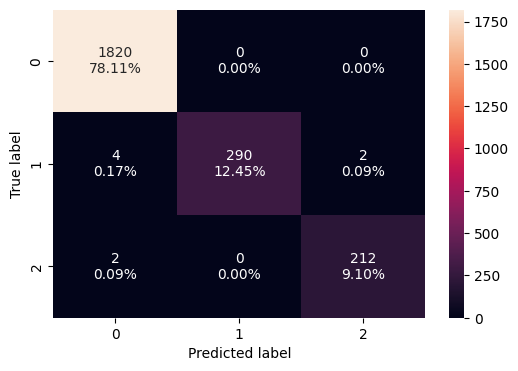

In [59]:
confusion_matrix_sklearn(rf_bow , X_train_bow , y_train_bow)

* Here, 0 represents negative, 1 represents neutral, and 2 represents positive sentiment

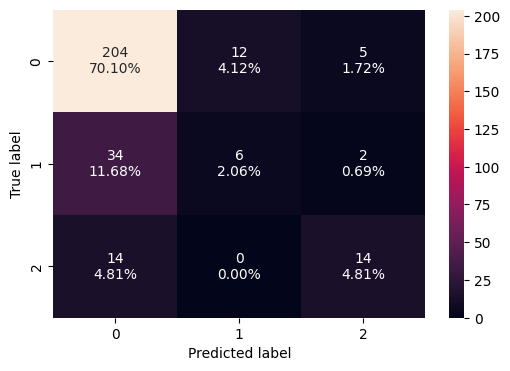

In [60]:
confusion_matrix_sklearn(rf_bow , X_valid_bow , y_valid_bow)

In [61]:
y_pred_train_bow = rf_bow.predict(X_train_bow)
y_pred_valid_bow = rf_bow.predict(X_valid_bow)

print('Classification report for training:\n ', classification_report(y_train_bow , y_pred_train_bow))
print('Classification report for validation:\n ', classification_report(y_valid_bow , y_pred_valid_bow))

Classification report for training:
                precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1820
     neutral       1.00      0.98      0.99       296
    positive       0.99      0.99      0.99       214

    accuracy                           1.00      2330
   macro avg       1.00      0.99      0.99      2330
weighted avg       1.00      1.00      1.00      2330

Classification report for validation:
                precision    recall  f1-score   support

    negative       0.81      0.92      0.86       221
     neutral       0.33      0.14      0.20        42
    positive       0.67      0.50      0.57        28

    accuracy                           0.77       291
   macro avg       0.60      0.52      0.54       291
weighted avg       0.73      0.77      0.74       291



- The model achieved an 77% recall score on the validation dataset.
- However, it failed to identify the positive and neutral reviews correctly in most cases.
- This might be due to the high imbalance of the target classes.


### Random Forest Model (with class weight and BOW)

In [62]:
rf_bow_cw = RandomForestClassifier(class_weight = 'balanced' , random_state = 42)
rf_bow_cw.fit(X_train_bow , y_train_bow)

RandomForestClassifier(class_weight='balanced', random_state=42)

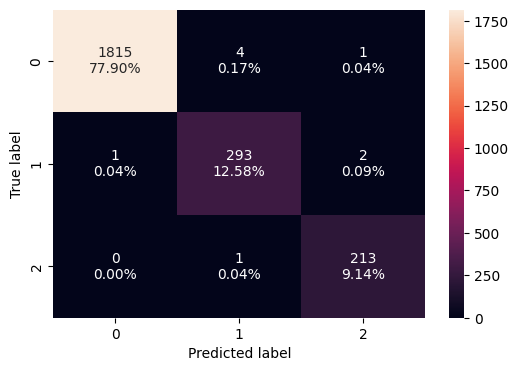

In [63]:
confusion_matrix_sklearn(rf_bow_cw , X_train_bow , y_train_bow)

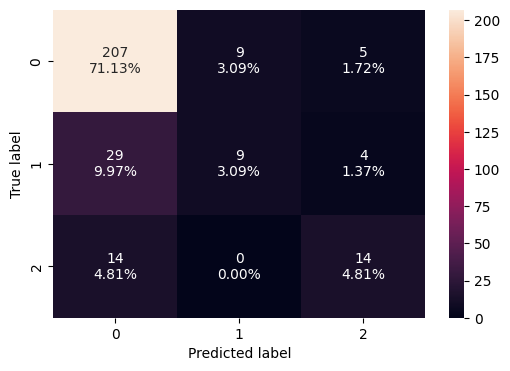

In [65]:
confusion_matrix_sklearn(rf_bow_cw , X_valid_bow , y_valid_bow)

In [66]:
y_pred_train_bow = rf_bow_cw.predict(X_train_bow)
y_pred_valid_bow = rf_bow_cw.predict(X_valid_bow)

print('Classification report for training:\n ', classification_report(y_train_bow , y_pred_train_bow))
print('Classification report for validation:\n ', classification_report(y_valid_bow , y_pred_valid_bow))

Classification report for training:
                precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1820
     neutral       0.98      0.99      0.99       296
    positive       0.99      1.00      0.99       214

    accuracy                           1.00      2330
   macro avg       0.99      0.99      0.99      2330
weighted avg       1.00      1.00      1.00      2330

Classification report for validation:
                precision    recall  f1-score   support

    negative       0.83      0.94      0.88       221
     neutral       0.50      0.21      0.30        42
    positive       0.61      0.50      0.55        28

    accuracy                           0.79       291
   macro avg       0.65      0.55      0.58       291
weighted avg       0.76      0.79      0.76       291



- The model's performance has improved slightly

### Random Forest Model (default with Word2Vec)

In [70]:
rf_w2v = RandomForestClassifier(random_state = 42)
rf_w2v.fit(X_train_w2v , y_train_w2v)

RandomForestClassifier(random_state=42)

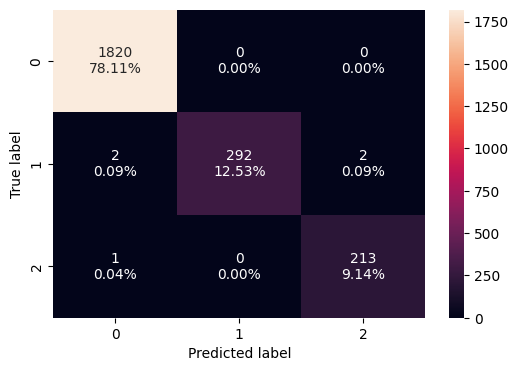

In [71]:
confusion_matrix_sklearn(rf_w2v , X_train_w2v , y_train_w2v)

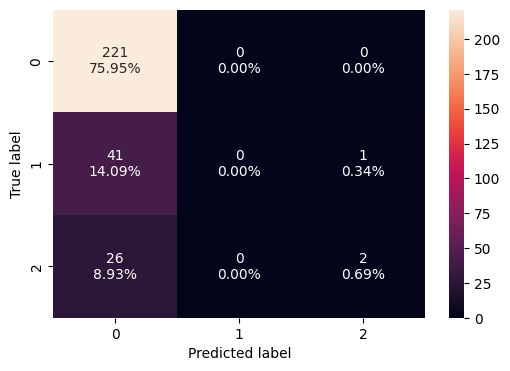

In [72]:
confusion_matrix_sklearn(rf_w2v , X_valid_w2v , y_valid_w2v)

In [73]:
y_pred_train_w2v = rf_w2v.predict(X_train_w2v)
y_pred_valid_w2v = rf_w2v.predict(X_valid_w2v)

print('Classification report for training:\n ', classification_report(y_train_w2v , y_pred_train_w2v))
print('Classification report for validation:\n ', classification_report(y_valid_w2v , y_pred_valid_w2v))

Classification report for training:
                precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1820
     neutral       1.00      0.99      0.99       296
    positive       0.99      1.00      0.99       214

    accuracy                           1.00      2330
   macro avg       1.00      0.99      1.00      2330
weighted avg       1.00      1.00      1.00      2330

Classification report for validation:
                precision    recall  f1-score   support

    negative       0.77      1.00      0.87       221
     neutral       0.00      0.00      0.00        42
    positive       0.67      0.07      0.13        28

    accuracy                           0.77       291
   macro avg       0.48      0.36      0.33       291
weighted avg       0.65      0.77      0.67       291



C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

- We can see that Random Forest with Word2Vec fails to identify neutral and positive class

### Random Forest Model (with class weight and Word2Vec)

In [74]:
rf_w2v_cw = RandomForestClassifier(class_weight = 'balanced' , random_state = 42)
rf_w2v_cw.fit(X_train_w2v , y_train_w2v)

RandomForestClassifier(class_weight='balanced', random_state=42)

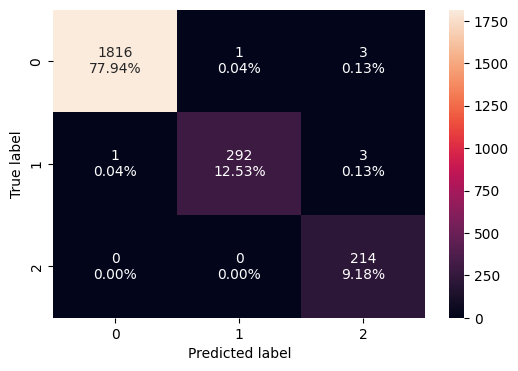

In [77]:
confusion_matrix_sklearn(rf_w2v_cw , X_train_w2v , y_train_w2v)

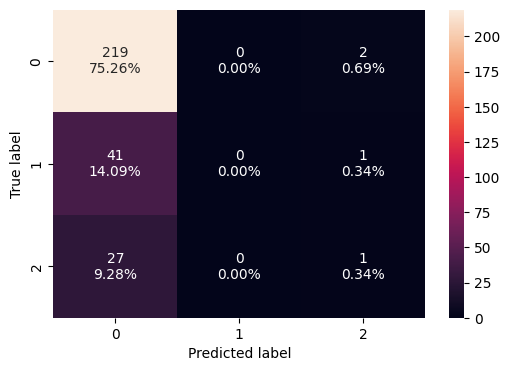

In [76]:
confusion_matrix_sklearn(rf_w2v_cw , X_valid_w2v , y_valid_w2v)

In [78]:
y_pred_train_w2v = rf_w2v_cw.predict(X_train_w2v)
y_pred_valid_w2v = rf_w2v_cw.predict(X_valid_w2v)

print('Classification report for training:\n ', classification_report(y_train_w2v , y_pred_train_w2v))
print('Classification report for validation:\n ', classification_report(y_valid_w2v , y_pred_valid_w2v))

Classification report for training:
                precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1820
     neutral       1.00      0.99      0.99       296
    positive       0.97      1.00      0.99       214

    accuracy                           1.00      2330
   macro avg       0.99      0.99      0.99      2330
weighted avg       1.00      1.00      1.00      2330

Classification report for validation:
                precision    recall  f1-score   support

    negative       0.76      0.99      0.86       221
     neutral       0.00      0.00      0.00        42
    positive       0.25      0.04      0.06        28

    accuracy                           0.76       291
   macro avg       0.34      0.34      0.31       291
weighted avg       0.60      0.76      0.66       291



C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

- Model's performance have decreased

### Random Forest Model (default with GloVe)

In [79]:
rf_glove = RandomForestClassifier(random_state = 42)
rf_glove.fit(X_train_glove , y_train_glove)

RandomForestClassifier(random_state=42)

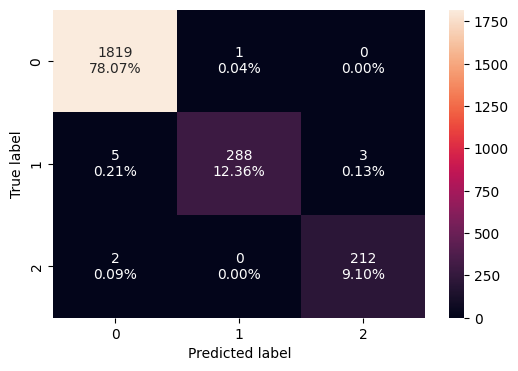

In [80]:
confusion_matrix_sklearn(rf_glove , X_train_glove , y_train_glove)

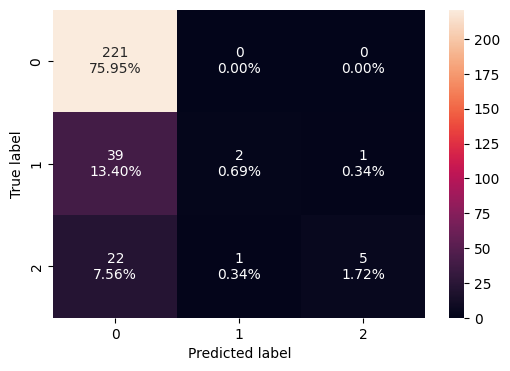

In [81]:
confusion_matrix_sklearn(rf_glove , X_valid_glove , y_valid_glove)

In [86]:
y_pred_train_glove = rf_glove.predict(X_train_glove)
y_pred_valid_glove = rf_glove.predict(X_valid_glove)

print('Classification report for training:\n ', classification_report(y_train_glove , y_pred_train_glove))
print('Classification report for validation:\n ', classification_report(y_valid_glove , y_pred_valid_glove))

Classification report for training:
                precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1820
     neutral       1.00      0.97      0.98       296
    positive       0.99      0.99      0.99       214

    accuracy                           1.00      2330
   macro avg       0.99      0.99      0.99      2330
weighted avg       1.00      1.00      1.00      2330

Classification report for validation:
                precision    recall  f1-score   support

    negative       0.78      1.00      0.88       221
     neutral       0.67      0.05      0.09        42
    positive       0.83      0.18      0.29        28

    accuracy                           0.78       291
   macro avg       0.76      0.41      0.42       291
weighted avg       0.77      0.78      0.71       291



### Random Forest Model (with class weights and GloVe)

In [83]:
rf_glove_cw = RandomForestClassifier(class_weight = 'balanced',random_state = 42)
rf_glove_cw.fit(X_train_glove , y_train_glove)

RandomForestClassifier(class_weight='balanced', random_state=42)

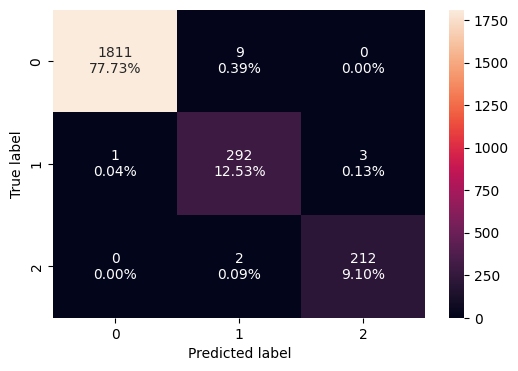

In [85]:
confusion_matrix_sklearn(rf_glove_cw , X_train_glove , y_train_glove)

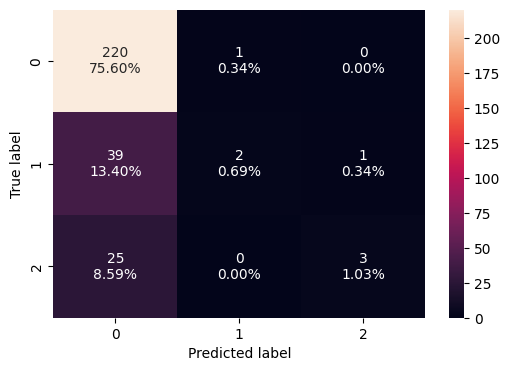

In [87]:
confusion_matrix_sklearn(rf_glove_cw , X_valid_glove , y_valid_glove)

In [88]:
y_pred_train_glove = rf_glove_cw.predict(X_train_glove)
y_pred_valid_glove = rf_glove_cw.predict(X_valid_glove)

print('Classification report for training:\n ', classification_report(y_train_glove , y_pred_train_glove))
print('Classification report for validation:\n ', classification_report(y_valid_glove , y_pred_valid_glove))

Classification report for training:
                precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1820
     neutral       0.96      0.99      0.97       296
    positive       0.99      0.99      0.99       214

    accuracy                           0.99      2330
   macro avg       0.98      0.99      0.99      2330
weighted avg       0.99      0.99      0.99      2330

Classification report for validation:
                precision    recall  f1-score   support

    negative       0.77      1.00      0.87       221
     neutral       0.67      0.05      0.09        42
    positive       0.75      0.11      0.19        28

    accuracy                           0.77       291
   macro avg       0.73      0.38      0.38       291
weighted avg       0.76      0.77      0.69       291



- Model's performance got worse
- Lets try tuning the model

### Random Forest (with hyperparameter tuning and BOW)

In [97]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 10, 2)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [5, 6],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = make_scorer(recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_bow, y_train_bow)

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


In [99]:
# Creating a new model with the best combination of parameters
rf_bow_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_bow_tuned.fit(X_train_bow, y_train_bow)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_split=5, n_estimators=30, random_state=42)

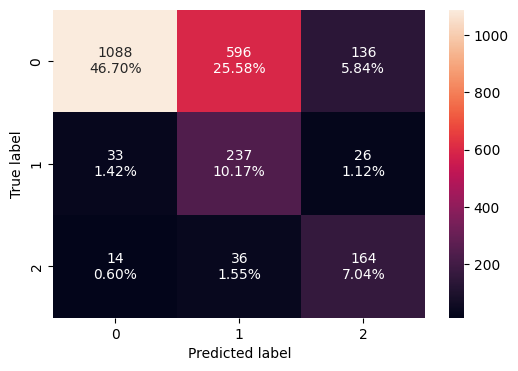

In [100]:
confusion_matrix_sklearn(rf_bow_tuned , X_train_bow , y_train_bow)

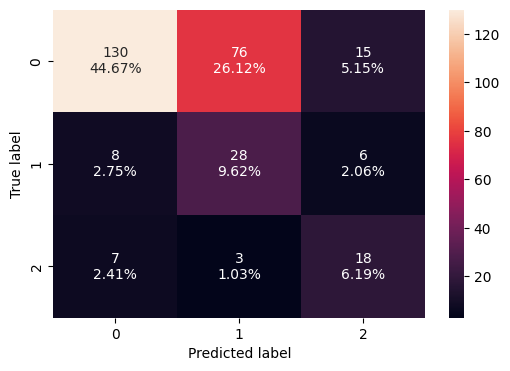

In [101]:
confusion_matrix_sklearn(rf_bow_tuned , X_valid_bow , y_valid_bow)

In [105]:
# Predicting on train data
y_pred_train_bow = rf_bow_tuned.predict(X_train_bow)

# Predicting on validation data
y_pred_valid_bow = rf_bow_tuned.predict(X_valid_bow)

print('Classification report for training:\n ', classification_report(y_train_bow , y_pred_train_bow))
print('Classification report for validation:\n ', classification_report(y_valid_bow , y_pred_valid_bow))

Classification report for training:
                precision    recall  f1-score   support

    negative       0.96      0.60      0.74      1820
     neutral       0.27      0.80      0.41       296
    positive       0.50      0.77      0.61       214

    accuracy                           0.64      2330
   macro avg       0.58      0.72      0.58      2330
weighted avg       0.83      0.64      0.68      2330

Classification report for validation:
                precision    recall  f1-score   support

    negative       0.90      0.59      0.71       221
     neutral       0.26      0.67      0.38        42
    positive       0.46      0.64      0.54        28

    accuracy                           0.60       291
   macro avg       0.54      0.63      0.54       291
weighted avg       0.76      0.60      0.65       291



- We can see now our model is identifying neutral and positive classes better but unable to classify negative class

### Random Forest (with hyperparameter tuning and Word2Vec)

In [108]:
from sklearn.model_selection import RandomizedSearchCV
rf_tuned = RandomForestClassifier(class_weight = 'balanced' , random_state = 42)

parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}
scorer = make_scorer(recall_score, average='weighted')

grid_obj = RandomizedSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_iter=10, n_jobs=2, random_state=42)
grid_obj = grid_obj.fit(X_train_w2v , y_train_w2v)

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [109]:
rf_tuned_w2v = grid_obj.best_estimator_
rf_tuned_w2v.fit(X_train_w2v , y_train_w2v)

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=0.7,
                       min_samples_split=7, n_estimators=30, random_state=42)

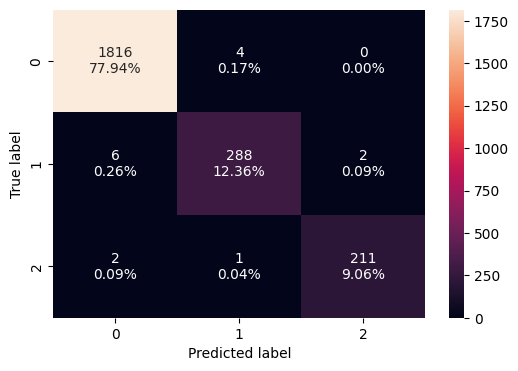

In [110]:
confusion_matrix_sklearn(rf_tuned_w2v , X_train_w2v , y_train_w2v)

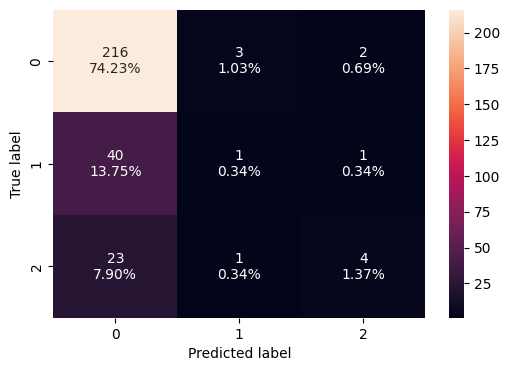

In [111]:
confusion_matrix_sklearn(rf_tuned_w2v , X_valid_w2v , y_valid_w2v)

In [113]:
# Predicting on train data
y_pred_train_w2v = rf_tuned_w2v.predict(X_train_w2v)

# Predicting on validation data
y_pred_valid_w2v = rf_tuned_w2v.predict(X_valid_w2v)

print('Classification report for training:\n ', classification_report(y_train_w2v , y_pred_train_w2v))
print('Classification report for validation:\n ', classification_report(y_valid_w2v , y_pred_valid_w2v))

Classification report for training:
                precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1820
     neutral       0.98      0.97      0.98       296
    positive       0.99      0.99      0.99       214

    accuracy                           0.99      2330
   macro avg       0.99      0.99      0.99      2330
weighted avg       0.99      0.99      0.99      2330

Classification report for validation:
                precision    recall  f1-score   support

    negative       0.77      0.98      0.86       221
     neutral       0.20      0.02      0.04        42
    positive       0.57      0.14      0.23        28

    accuracy                           0.76       291
   macro avg       0.52      0.38      0.38       291
weighted avg       0.67      0.76      0.68       291



### Random Forest (with hyperparameter tuning and GloVe)

In [114]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": [5, 10, 15],  
    "max_features": ["sqrt"],  
    "min_samples_split": [5, 7],  
    "n_estimators": [50, 100] 
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = make_scorer(recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_glove, y_train_glove)

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [115]:
rf_tuned_glove = grid_obj.best_estimator_
rf_tuned_glove.fit(X_train_glove , y_train_glove)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=50, random_state=42)

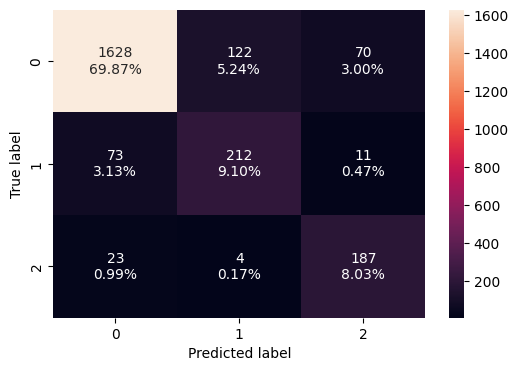

In [116]:
confusion_matrix_sklearn(rf_tuned_glove , X_train_glove , y_train_glove)

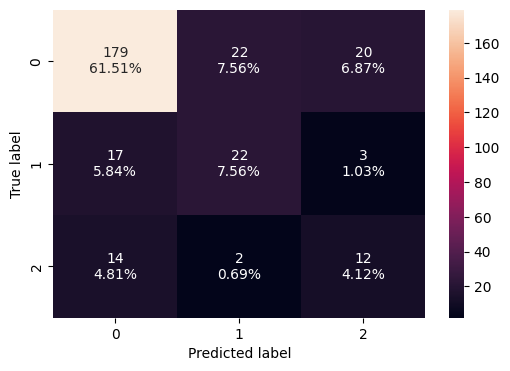

In [117]:
confusion_matrix_sklearn(rf_tuned_glove , X_valid_glove , y_valid_glove)

In [118]:
# Predicting on train data
y_pred_train_glove = rf_tuned_glove.predict(X_train_glove)

# Predicting on validation data
y_pred_valid_glove = rf_tuned_glove.predict(X_valid_glove)

print('Classification report for training:\n ', classification_report(y_train_glove , y_pred_train_glove))
print('Classification report for validation:\n ', classification_report(y_valid_glove , y_pred_valid_glove))

Classification report for training:
                precision    recall  f1-score   support

    negative       0.94      0.89      0.92      1820
     neutral       0.63      0.72      0.67       296
    positive       0.70      0.87      0.78       214

    accuracy                           0.87      2330
   macro avg       0.76      0.83      0.79      2330
weighted avg       0.88      0.87      0.87      2330

Classification report for validation:
                precision    recall  f1-score   support

    negative       0.85      0.81      0.83       221
     neutral       0.48      0.52      0.50        42
    positive       0.34      0.43      0.38        28

    accuracy                           0.73       291
   macro avg       0.56      0.59      0.57       291
weighted avg       0.75      0.73      0.74       291



- As we can see amongst all the models ,  tuned Random Forest model with GloVe embeddings identifies neutral and positive classes better

## Model Testing

We'll check the performance of the tune Random Forest model with GloVe encoding on the test set.

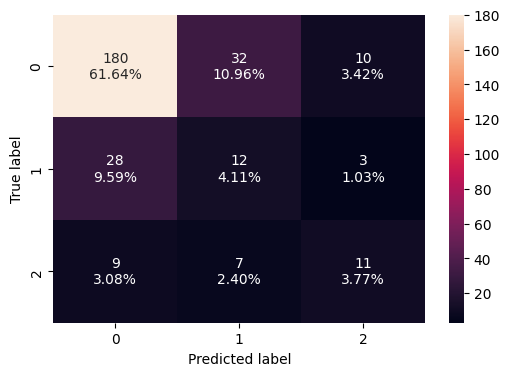

In [119]:
confusion_matrix_sklearn(rf_tuned_glove , X_test_glove , y_test_glove)

In [120]:
y_pred_test_glove = rf_tuned_glove.predict(X_test_glove)

print(classification_report(y_test_glove, y_pred_test_glove))

              precision    recall  f1-score   support

    negative       0.83      0.81      0.82       222
     neutral       0.24      0.28      0.26        43
    positive       0.46      0.41      0.43        27

    accuracy                           0.70       292
   macro avg       0.51      0.50      0.50       292
weighted avg       0.71      0.70      0.70       292



- The model achieved a recall of 70%
- We can try balancing the classes that will improve the performance of our model